In [1]:
 !pip install yfinance pandas numpy scipy

Descargando datos...
Descargando XLK...
Descargando XLY...
Descargando XLI...
Descargando XLP...
Descargando XLU...
Descargando XLV...
Descargando ^VIX...
Descargando ^VIX3M...
Datos descargados. Shape: (1997, 9)
Calculando oscilador...
Oscilador calculado. Shape: (1997, 8)
Creando gráfico del oscilador...


<ipython-input-6-483c907f6221>:283: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


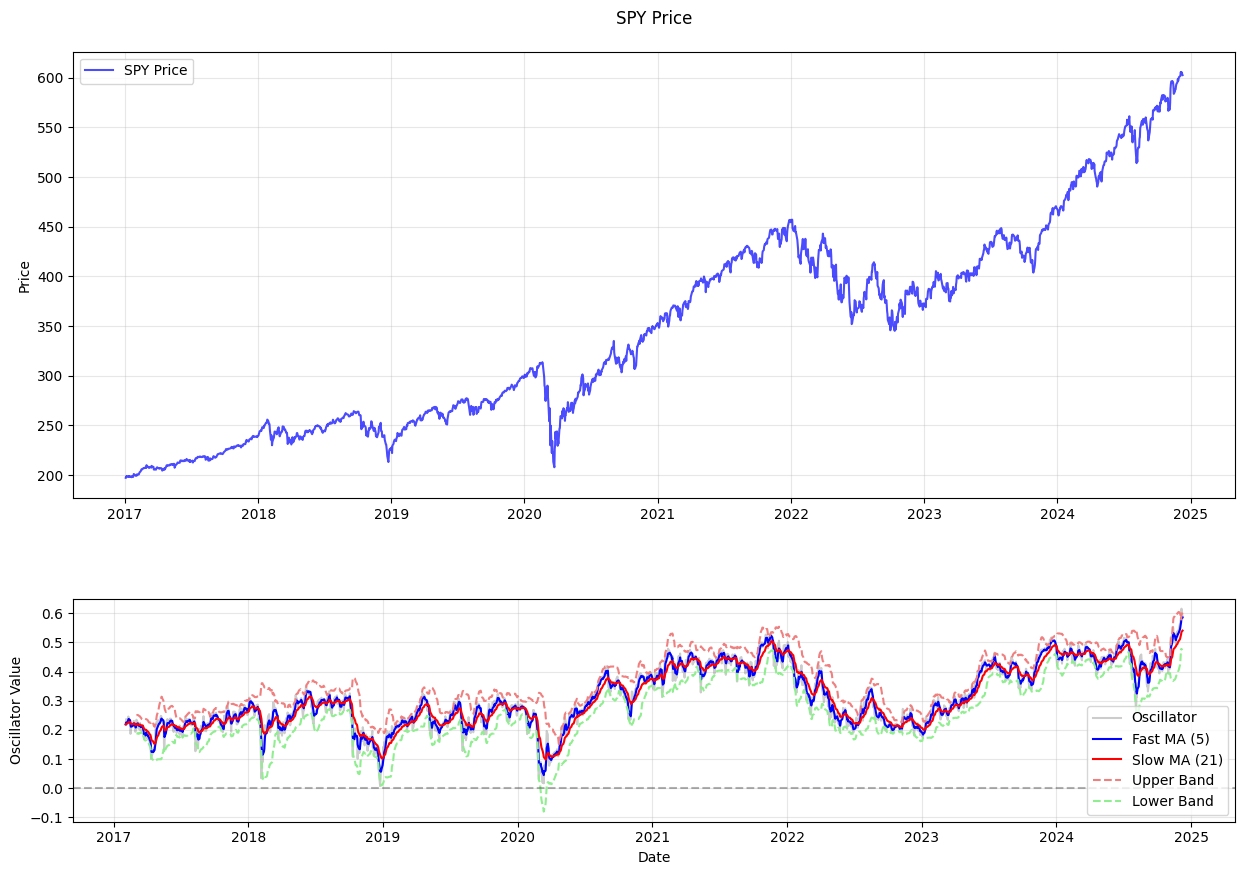


Realizando backtest...
Creando gráficos de backtest...


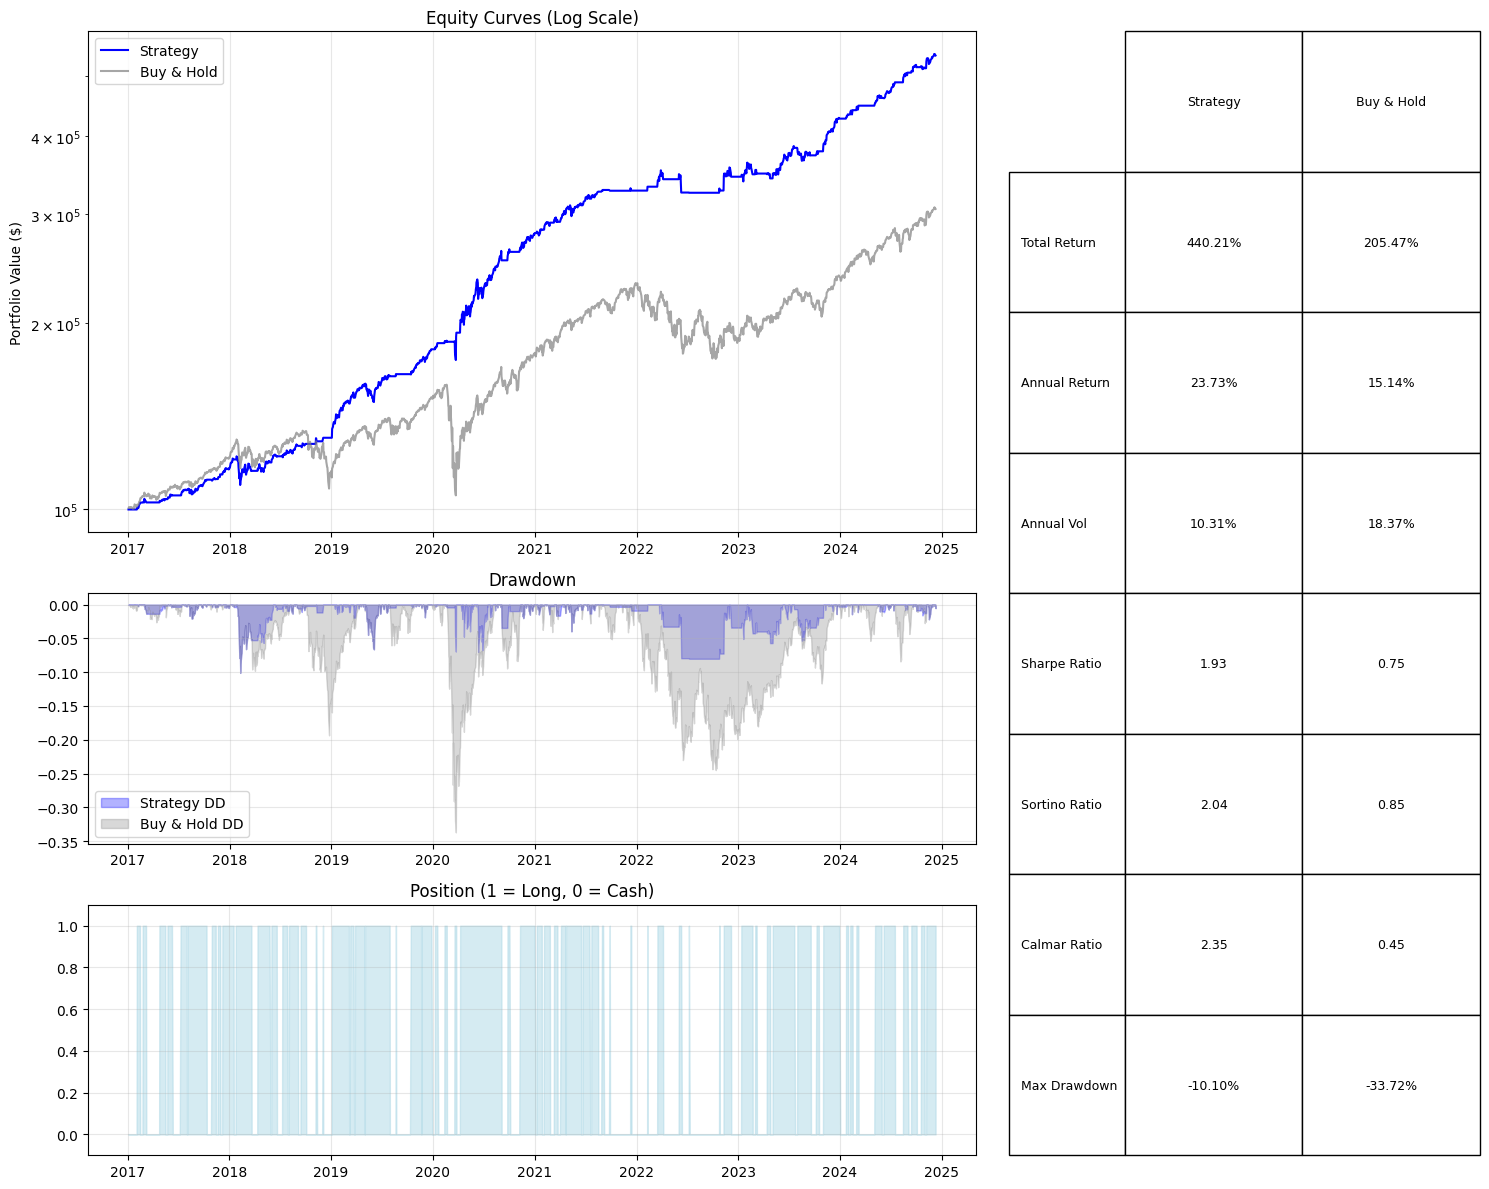


Estadísticas de señales:
Número de señales de compra: 69
Número de señales de venta: 67

Métricas de la estrategia:
Retorno total: 440.21%
Retorno anual: 23.73%
Volatilidad anual: 10.31%
Ratio de Sharpe: 1.93
Máximo drawdown: -10.10%


In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from datetime import datetime

def fetch_data(start_date='2017-01-01', end_date='2024-12-10'):
    print("Descargando datos...")
    spy = yf.download('SPY', start=start_date, end=end_date, progress=False)
    data = pd.DataFrame(index=spy.index)
    data['SPY'] = spy['Close']

    other_tickers = ['XLK', 'XLY', 'XLI', 'XLP', 'XLU', 'XLV', '^VIX', '^VIX3M']

    for ticker in other_tickers:
        print(f"Descargando {ticker}...")
        df = yf.download(ticker, start=start_date, end=end_date, progress=False)
        data[ticker] = df['Close']

    data = data.dropna()
    return data

def calculate_performance_metrics(returns, risk_free_rate=0.02):
    """Calcula métricas de rendimiento para una serie de retornos"""
    rf_daily = (1 + risk_free_rate) ** (1/252) - 1
    total_return = (1 + returns).prod() - 1
    years = len(returns) / 252
    annual_return = (1 + total_return) ** (1/years) - 1
    daily_vol = returns.std()
    annual_vol = daily_vol * np.sqrt(252)
    excess_returns = returns - rf_daily
    sharpe_ratio = np.sqrt(252) * excess_returns.mean() / returns.std()
    cum_returns = (1 + returns).cumprod()
    rolling_max = cum_returns.expanding().max()
    drawdowns = cum_returns / rolling_max - 1
    max_drawdown = drawdowns.min()
    negative_returns = returns[returns < 0]
    downside_vol = negative_returns.std() * np.sqrt(252)
    sortino_ratio = (annual_return - risk_free_rate) / downside_vol if downside_vol != 0 else np.nan
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

    return {
        'Total Return': total_return,
        'Annual Return': annual_return,
        'Annual Volatility': annual_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Calmar Ratio': calmar_ratio,
        'Max Drawdown': max_drawdown
    }

def backtest_strategy(df, initial_capital=100000):
    """Realiza el backtest de la estrategia y buy & hold"""
    daily_returns = df['price'].pct_change()
    position = 0
    strategy_returns = []
    equity = initial_capital
    equity_curve = [initial_capital]
    positions = []

    for i in range(1, len(df)):
        if position == 0 and df['buy_signal'].iloc[i] == 1:
            position = 1
        elif position == 1 and df['sell_signal'].iloc[i] == 1:
            position = 0

        if position == 1:
            ret = daily_returns.iloc[i]
        else:
            ret = 0

        strategy_returns.append(ret)
        positions.append(position)
        equity *= (1 + ret)
        equity_curve.append(equity)

    strategy_returns = pd.Series(strategy_returns, index=df.index[1:])
    positions = pd.Series(positions, index=df.index[1:])
    equity_curve = pd.Series(equity_curve, index=df.index)
    bh_equity = initial_capital * (1 + daily_returns).cumprod()
    bh_returns = daily_returns

    return {
        'strategy_returns': strategy_returns,
        'bh_returns': bh_returns[1:],
        'strategy_equity': equity_curve,
        'bh_equity': bh_equity,
        'positions': positions
    }

def plot_backtest_results(backtest_results, metrics_strategy, metrics_bh):
    """Visualiza los resultados del backtest"""
    fig = plt.figure(figsize=(15, 12))
    gs = GridSpec(3, 2, height_ratios=[2, 1, 1], width_ratios=[2, 1])

    # Subplot 1: Equity Curves (Log scale)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.semilogy(backtest_results['strategy_equity'],
             label='Strategy', color='blue', linewidth=1.5)
    ax1.semilogy(backtest_results['bh_equity'],
             label='Buy & Hold', color='gray', linewidth=1.5, alpha=0.7)
    ax1.set_title('Equity Curves (Log Scale)')
    ax1.set_ylabel('Portfolio Value ($)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Subplot 2: Drawdown
    ax2 = fig.add_subplot(gs[1, 0])
    strategy_dd = (backtest_results['strategy_equity'] /
                  backtest_results['strategy_equity'].expanding().max() - 1)
    bh_dd = (backtest_results['bh_equity'] /
             backtest_results['bh_equity'].expanding().max() - 1)

    ax2.fill_between(strategy_dd.index, strategy_dd, 0,
                     color='blue', alpha=0.3, label='Strategy DD')
    ax2.fill_between(bh_dd.index, bh_dd, 0,
                     color='gray', alpha=0.3, label='Buy & Hold DD')
    ax2.set_title('Drawdown')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # Subplot 3: Position over time
    ax3 = fig.add_subplot(gs[2, 0])
    ax3.fill_between(backtest_results['positions'].index,
                     backtest_results['positions'],
                     color='lightblue', alpha=0.5)
    ax3.set_title('Position (1 = Long, 0 = Cash)')
    ax3.set_ylim(-0.1, 1.1)
    ax3.grid(True, alpha=0.3)

    # Subplot 4: Metrics Comparison
    ax4 = fig.add_subplot(gs[:, 1])
    metrics_comparison = pd.DataFrame({
        'Strategy': [
            f"{metrics_strategy['Total Return']:.2%}",
            f"{metrics_strategy['Annual Return']:.2%}",
            f"{metrics_strategy['Annual Volatility']:.2%}",
            f"{metrics_strategy['Sharpe Ratio']:.2f}",
            f"{metrics_strategy['Sortino Ratio']:.2f}",
            f"{metrics_strategy['Calmar Ratio']:.2f}",
            f"{metrics_strategy['Max Drawdown']:.2%}"
        ],
        'Buy & Hold': [
            f"{metrics_bh['Total Return']:.2%}",
            f"{metrics_bh['Annual Return']:.2%}",
            f"{metrics_bh['Annual Volatility']:.2%}",
            f"{metrics_bh['Sharpe Ratio']:.2f}",
            f"{metrics_bh['Sortino Ratio']:.2f}",
            f"{metrics_bh['Calmar Ratio']:.2f}",
            f"{metrics_bh['Max Drawdown']:.2%}"
        ]
    }, index=[
        'Total Return',
        'Annual Return',
        'Annual Vol',
        'Sharpe Ratio',
        'Sortino Ratio',
        'Calmar Ratio',
        'Max Drawdown'
    ])

    ax4.axis('tight')
    ax4.axis('off')
    table = ax4.table(cellText=metrics_comparison.values,
                     rowLabels=metrics_comparison.index,
                     colLabels=metrics_comparison.columns,
                     cellLoc='center',
                     loc='center',
                     bbox=[0.2, 0, 0.8, 1])

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)

    plt.tight_layout()
    return fig

def calculate_oscillator(df):
    try:
        # Calculate EMAs for SPY
        spy_ema8 = df['SPY'].ewm(span=8, adjust=False).mean()
        spy_ema24 = df['SPY'].ewm(span=24, adjust=False).mean()

        # Calculate momentum
        momentum = df['SPY'].pct_change(21)

        # Calculate Cyclical/Defensive ratio
        cyclical = df[['XLK', 'XLY', 'XLI']].mean(axis=1)
        defensive = df[['XLP', 'XLU', 'XLV']].mean(axis=1)
        cycl_def_ratio = cyclical / defensive

        # Calculate VIX ratio
        vix_ratio = df['^VIX'] / df['^VIX3M']

        # Calculate the raw oscillator
        oscillator = (
            2 * ((spy_ema8 - spy_ema24) / spy_ema24) *
            momentum + 0.5 * (cycl_def_ratio - vix_ratio)
        )

        # Calcular medias del oscilador
        ma_rapida = oscillator.ewm(span=5, adjust=False).mean()
        ma_lenta = oscillator.ewm(span=21, adjust=False).mean()

        # Calcular bandas de volatilidad
        volatility = oscillator.rolling(window=21).std()
        upper_band = ma_lenta + 2 * volatility
        lower_band = ma_lenta - 2 * volatility

        # Señales basadas en cruces
        prev_ma_rapida = ma_rapida.shift(1)
        prev_ma_lenta = ma_lenta.shift(1)

        # Señales de compra
        cross_up = (ma_rapida > ma_lenta) & (prev_ma_rapida <= prev_ma_lenta)
        bounce_up = (ma_rapida > lower_band) & (prev_ma_rapida <= lower_band)
        buy_signals = (cross_up | bounce_up).astype(int)

        # Señales de venta
        cross_down = (ma_rapida < ma_lenta) & (prev_ma_rapida >= prev_ma_lenta)
        bounce_down = (ma_rapida < upper_band) & (prev_ma_rapida >= upper_band)
        sell_signals = (cross_down | bounce_down).astype(int)

        # Filtrar señales muy cercanas
        min_days = 10
        for i in range(min_days, len(buy_signals)):
            if buy_signals.iloc[i] == 1:
                if buy_signals.iloc[i-min_days:i].sum() > 0:
                    buy_signals.iloc[i] = 0

        for i in range(min_days, len(sell_signals)):
            if sell_signals.iloc[i] == 1:
                if sell_signals.iloc[i-min_days:i].sum() > 0:
                    sell_signals.iloc[i] = 0

        results = pd.DataFrame({
            'price': df['SPY'],
            'oscillator': oscillator,
            'ma_rapida': ma_rapida,
            'ma_lenta': ma_lenta,
            'upper_band': upper_band,
            'lower_band': lower_band,
            'buy_signal': buy_signals,
            'sell_signal': sell_signals
        })

        return results

    except Exception as e:
        print(f"Error en calculate_oscillator: {str(e)}")
        raise

def plot_oscillator(df):
    """Plot oscillator without triangles"""
    plt.style.use('default')
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 1, height_ratios=[2, 1], hspace=0.3)

    # Subplot 1: SPY Price
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(df.index, df['price'], label='SPY Price', color='blue', alpha=0.7)
    ax1.set_title('SPY Price', pad=20)
    ax1.set_xlabel('')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Subplot 2: Oscillator with MAs and bands
    ax2 = fig.add_subplot(gs[1])
    ax2.plot(df.index, df['oscillator'], label='Oscillator', color='gray', alpha=0.4)
    ax2.plot(df.index, df['ma_rapida'], label='Fast MA (5)', color='blue', linewidth=1.5)
    ax2.plot(df.index, df['ma_lenta'], label='Slow MA (21)', color='red', linewidth=1.5)
    ax2.plot(df.index, df['upper_band'], label='Upper Band', color='lightcoral', linestyle='--')
    ax2.plot(df.index, df['lower_band'], label='Lower Band', color='lightgreen', linestyle='--')

    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Oscillator Value')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

def main():
    try:
        # Fetch data
        market_data = fetch_data()
        print(f"Datos descargados. Shape: {market_data.shape}")

        # Calculate oscillator
        print("Calculando oscilador...")
        results = calculate_oscillator(market_data)
        print(f"Oscilador calculado. Shape: {results.shape}")

        # Create and show oscillator plot
        print("Creando gráfico del oscilador...")
        fig_osc = plot_oscillator(results)
        plt.show()

        # Realizar backtest
        print("\nRealizando backtest...")
        backtest_results = backtest_strategy(results)

        # Calcular métricas de rendimiento
        strategy_metrics = calculate_performance_metrics(backtest_results['strategy_returns'])
        bh_metrics = calculate_performance_metrics(backtest_results['bh_returns'])

        # Mostrar gráficos de backtest
        print("Creando gráficos de backtest...")
        fig_backtest = plot_backtest_results(backtest_results, strategy_metrics, bh_metrics)
        plt.show()

        # Imprimir estadísticas de señales
        n_buy = results['buy_signal'].sum()
        n_sell = results['sell_signal'].sum()
        print(f"\nEstadísticas de señales:")
        print(f"Número de señales de compra: {n_buy}")
        print(f"Número de señales de venta: {n_sell}")

        # Imprimir métricas principales
        print("\nMétricas de la estrategia:")
        print(f"Retorno total: {strategy_metrics['Total Return']:.2%}")
        print(f"Retorno anual: {strategy_metrics['Annual Return']:.2%}")
        print(f"Volatilidad anual: {strategy_metrics['Annual Volatility']:.2%}")
        print(f"Ratio de Sharpe: {strategy_metrics['Sharpe Ratio']:.2f}")
        print(f"Máximo drawdown: {strategy_metrics['Max Drawdown']:.2%}")

        return results, backtest_results, strategy_metrics, bh_metrics

    except Exception as e:
        print(f"Error en main: {str(e)}")
        raise

if __name__ == "__main__":
    results, backtest_results, strategy_metrics, bh_metrics = main()